##  Preprocessing using *.csv files and Postprocessing to Plot for SUMMA using PySUMMA 

## 1. Introduction

In this Jupyter Notebook, the PySUMMA library is used to create new SUMMA input from *. csv files that include initial condition, local attributes, parameters, and forcing data for the preprocessing. For the postprocessing, the PySUMMA supports various plotting method as time series, 2d(heat map, hovmoller etc. Especially, this example used to reproduce the lateral flow parameterization(distributed method) in the Clark et al., (2015b) study. This example is good to consider watershed where have two or more than HRUs.

Following the step of this notebook
1. Creating SUMMA input from *.csv files
2. Run SUMMA Model using PySUMMA
3. Plotting with SUMMA output
- Time series Plotting
- 2D Plotting (heatmap, hovmoller)
- Calculating water balance variables and Plotting
- Spatial Plotting with shapefile

## 2. Background

### The Transpiration from soil layers available in SUMMA

In [1]:
#import libraries to display equations within the notebook
from IPython.display import display, Math, Latex

### Latertal flux from the soil profile

The continuity equation for sub-surface storage (i.e., below the water table) can be written for a given model element as [Wigmosta et al., 1994]

\begin{equation*}
Q_{dr} = \frac{dz_{wt}}{dt} = \frac{Q_{out}-Q_{in}}{A} - q_{rchg}
\end{equation*}

$Q_{dr} = (\theta_{sat}^{soil} - \theta_{fc}^{soil}) $ : “drainable” porosity, $\theta_{fc}^{soil}$ : the field capacity of soil, $z_{wt}$ $(m)$ : the depth to the water table

$Q_{out}$ and $Q_{in}$ $(m^{3}/s)$: the lateral inflow and outflow, $q_{rchg}$ $(m/s)$ : the vertical recharge rate, $A$ $(m^2)$ : the element area

#### Storage-based implementation to represent lateral flow between soil columns

The “drainable” water storage and the maximum drainable water storage can be given as
\begin{equation*}
W_{dr}^{soil} = \int_{z_{crit}}^{z_{soil}}\ [\theta_{liq}^{soil} (z) - \theta_{fc}^{soil} ] \mathrm{d}z, \          W_{dr,max}^{soil} = \phi_{dr}z_{soil}
\end{equation*}

$\theta_{liq}^{soil} (z)$ : the volumetric liquid water content at soil depth z, $z_{crit}$ : the lowest point in the soil profile where $\theta_{liq}^{soil}$ < $\theta_{fc}^{soil}$

#### The total lateral outflow

\begin{equation*}
Q_{out} = x_{len}tan(\beta) \frac{K_{sat}^{0} W_{dr,max}^{soil}}{\phi_{dr}n_{sf}}[\frac{W_{dr}^{soil}}{W_{dr,max}^{soil}}]^{n_{sf}}
\end{equation*}

$\beta$ : the gradient in the land surface, used to approximate the water table gradient

#### The total lateral flux

\begin{equation*}
q_{base}^{soil} =  \frac{Q_{out}-Q_{in}}{A}
\end{equation*}

The total lateral flux $q_{base}^{soil}$ can then be apportioned to individual soil layers, obtained after spatial discretization described in Clark et al. [2015b], to provide the lateral flow sink term

\begin{equation*}
(S_{lf})_{j} = (w_{tv})_{j}   q_{base}^{soil}
\end{equation*}

$(w_{tv})_{j}$ : the ratio of the transmissivity of the $j$-th layer to the total transmissivity

The above descriptions are taken from the lateral flux from the soil profile section(3.2.3.5) within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [2]:
from ipyleaflet import Map, GeoJSON
import json

In [3]:
m = Map(center=[43.06745, -116.75489], zoom=15)
with open('data/map/reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[43.06745, -116.75489], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), GeoJSON(data={'type': 'FeatureCollection', 'name': 'reynolds_geojson_latlon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}, 'features': [{'type': 'Feature', 'properties': {'OBJECTID': 1, 'RCEW_REGIO': 376208.194027, 'PERIMETER': 3340.0, 'RMEAST_MAS': 2, 'RMEAST_M_1': 2, 'GRID_CODE': 1}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-116.7557156288284, 43.07072983625339], [-116.75559279969227, 43.07072957489522], [-116.75559315872648, 43.07063952502811], [-116.75547032977175, 43.07063926353894], [-116.75534750204696, 43.07063900192053], [-116.75522467432737, 43.07063873926983], [-116.7551018453776, 43.07063847738518], [-116.75510220512943, 43.0705484275199], [-116.75497937636112, 43.07054816550426], [-116.75497973629112, 43.070458115638395], [-116.75485690770425, 43.07045785349174], [-116.7547340803473, 43.07045759121584], [-116.754611252992, 43.070457328808125], [-116.75448842441011, 43.07045706626597], [-116.75436559706174, 43.070456802694125], [-116.75424276848315, 43.07045653988829], [-116.75424312949033, 43.070366490025975], [-116.75412030232148, 43.070366227091775], [-116.75399747392602, 43.0703659640231], [-116.75399783529119, 43.07027591416101], [-116.75387500707716, 43.07027565096134], [-116.7537521800931, 43.07027538763253], [-116.75362935188241, 43.07027512416918], [-116.75362971378532, 43.07018507430818], [-116.75363007445833, 43.07009502444305], [-116.75363043635795, 43.07000497457918], [-116.75363079702761, 43.06991492471125], [-116.75375362451547, 43.06991518907176], [-116.75375398500368, 43.06982513920156], [-116.75375434671845, 43.06973508933261], [-116.75375470720336, 43.06964503945952], [-116.75363188147955, 43.06964477600465], [-116.7536322421426, 43.069554726130995], [-116.75350941660027, 43.06955446254514], [-116.75350977744145, 43.06946441267091], [-116.75338695208056, 43.06946414895402], [-116.75338731309988, 43.0693740990792], [-116.75326448792045, 43.06937383523132], [-116.75326485034614, 43.06928378535855], [-116.75314202411995, 43.06928352137701], [-116.75301919912368, 43.069283257266314], [-116.75301956067906, 43.06919320739113], [-116.753019923461, 43.06910315751716], [-116.75289709759774, 43.069102893273666], [-116.7527742729644, 43.06910262890097], [-116.75277463610426, 43.06901257902725], [-116.75265181042415, 43.069012314520926], [-116.75265217374212, 43.06892226464661], [-116.75252934824346, 43.06892200000929], [-116.75252971173958, 43.06883195013435], [-116.7525300740058, 43.0687419002554], [-116.75240725009662, 43.068741635490554], [-116.75240761254095, 43.06865158561097], [-116.75240797621186, 43.06856153573259], [-116.75240833865288, 43.06847148585014], [-116.7524087023168, 43.06838143686942], [-116.75228587790387, 43.06838117107297], [-116.75228624174592, 43.068291122091665], [-116.7522866043617, 43.068201072205795], [-116.75228696820399, 43.06811102232113], [-116.75228733081644, 43.06802097243243], [-116.75228769465541, 43.067930922544896], [-116.75228805726088, 43.067840873553784], [-116.75228842109648, 43.06775082366344], [-116.75216559794013, 43.06775055864152], [-116.75216596195388, 43.06766050875055], [-116.75204313897898, 43.06766024359765], [-116.75192031723756, 43.067659977415076], [-116.7517974954942, 43.067659712001166], [-116.75167467252432, 43.06765944645277], [-116.75167503725551, 43.06756939656374], [-116.75167540075684, 43.067479346670616], [-116.75167576548104, 43.067389297679235], [-116.75167612897903, 43.06729924778324], [-116.75155330795809, 43.067298982109065], [-116.75155367163417, 43.06720893221254], [-116.75155403653679, 43.06711888231719], [-116.7515544002095, 43.06702883241775

### 2) Creating SUMMA input from *.csv files

In [1]:
from pysumma.Simulation import Simulation
from pysumma.Preprocess_csv import *
import os

#### Set the directory of *.csv files

In [5]:
# set a Trial parameters file which specifies model parameters enabling users to overwrite the dafault parameter values
ParamTrial_path = os.getcwd() + '/' + "param_trial.csv"
# set a local attributes files which specifies model element attributes
LocalAttribute_path = os.getcwd() + '/' + "local_attribute.csv"
# set a initial conditions files that has the same number of row data with the number of hru
hru_path = os.getcwd() + '/' + "initial_cond_hru.csv"
# set a initial conditions files that has the same number of row data with the number of ifcToto.
# "ifc" are associated with variables that are specified at the interfaces between layers including the very top and bottom. 
# "Toto" indicates snow and soil layers together.
ifcToto_path = os.getcwd() + '/' + "initial_cond_ifc.csv"
# set a initial conditions files that has the same number of row data with the number of midToto.
# "mid" are associated with variables that are specified at the mid-point of each layer (or layer-average). 
midToto_path = os.getcwd() + '/' + "initial_cond_mid.csv"
# set meteorological forcing files
forcing_data_path = os.getcwd() + '/' + "forcing_dist.csv"

In [2]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_distributedTopmodel = Simulation(os.getcwd() + '/settings/summa_fileManager_distributedTopmodel.txt')

ModelOuput master file filepath: /media/sf_pysumma/pysumma/pysumma/preprocess/SummaModel_Reynolds_Runoff/settings/meta/var_lookup.f90


In [7]:
# get the name of a Trial parameters file from SUMMA file manager
param_name = S_distributedTopmodel.para_trial.filename
# create a NetCDF file of a Trial parameters
ParamTrial_from_csv(ParamTrial_path, param_name)

In [8]:
# get the name of a local attributes files from SUMMA file manager
localAttri_name = S_distributedTopmodel.local_attr.filename
# create a NetCDF file of a local attributes files
LocalAttribute_from_csv(LocalAttribute_path, localAttri_name)

In [9]:
# get the name of a initial conditions files from SUMMA file manager
initial_name = S_distributedTopmodel.initial_cond.filename
# create a NetCDF file of a initial conditions files
InitialCond_from_csv(hru_path, ifcToto_path, midToto_path, initial_name)

In [10]:
# get the file name which includes forcing file lists from SUMMA file manager
forcing_list = S_distributedTopmodel.forcing_list.filename

In [11]:
# get the name of a forcing file
forcing_list_text = open(os.getcwd() + '/settings/' + forcing_list, "r")
forcing_name_file = forcing_list_text.read()
forcing_name = forcing_name_file.split("'")[1]
forcing_name

'forcing_reynolds_distributed.nc'

In [12]:
# set initial date and time, and create a NetCDF file of a forcing files
forcingdata_from_csv(forcing_data_path, LocalAttribute_path, forcing_name, '2001-01-01 00:00:00')

### 3) Run SUMMA Model using PySUMMA

In [13]:
# set the simulation start and finish times
S_distributedTopmodel.decision_obj.simulStart.value = '2003-10-01 00:00'
S_distributedTopmodel.decision_obj.simulFinsh.value = '2008-09-30 00:00'

In [14]:
# check the simulation start and finish times
S_distributedTopmodel.decision_obj.simulStart.value, S_distributedTopmodel.decision_obj.simulFinsh.value

('2003-10-01 00:00', '2008-09-30 00:00')

#### If you already have a SUMMA output file, you don't need to execute SUMMA again. Move next

In [18]:
# run the model giving the output the suffix "distributedTopmodel" and get "results_distributedTopmodel" and "output_DT" object
results_distributedTopmodel, output_DT = S_distributedTopmodel.execute(run_suffix="distributedTopmodel", run_option = 'docker_sopron_2018')

file_suffix is 'distributedTopmodel'.
file_master is '/media/sf_pysumma/pysumma/pysumma/preprocess/SummaModel_Reynolds_Runoff/settings/summa_fileManager_distributedTopmodel.txt'.
start at 00:00:37
Name of Model Output control file: /media/sf_pysumma/pysumma/pysumma/preprocess/SummaModel_Reynolds_Runoff/settings/meta/Model_Output.txt
decisions file =  /media/sf_pysumma/pysumma/pysumma/preprocess/SummaModel_Reynolds_Runoff/settings/summa_zDecisions_distributedTopmodel.txt
   1 simulStart: 2003-10-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: specified
  10 f_Richards: mixdform
  11 groundwatr: qTopmodl
  12 hc_profile: pow_prof
  13 bcUpprTdyn: nrg_flux
  14 bcLowrTdyn: zeroFlux
  15 bcUpprSoiH: liq_flux
  16 bcLowrSoiH: zeroFlux
  17 veg_traits: CM_QJRMS1988
  18 canopyEmis: difTrans
  19 snowIncept: lightSnow
  20 windPrfi

In [3]:
# if you executed SUMMA, get SUMMA output and output path.
results_distributedTopmodel, output_DT = S_distributedTopmodel.get_output("docker_sopron", run_suffix = "distributedTopmodel")

## 4. Plotting with SUMMA output

In [67]:
from pysumma.Plotting import Plotting
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import pandas as pd
jtplot.figsize(x=15, y=5)

In [7]:
# explore SUMMA output : Dimenstions, Data variables etc
results_distributedTopmodel

<xarray.Dataset>
Dimensions:                    (gru: 1, hru: 6, ifcSoil: 9, ifcToto: 14, midSoil: 8, midToto: 13, time: 43825)
Coordinates:
  * time                       (time) datetime64[ns] 2003-10-01 ...
  * hru                        (hru) int32 1 2 3 4 5 6
Dimensions without coordinates: gru, ifcSoil, ifcToto, midSoil, midToto
Data variables:
    pptrate                    (time, hru) float64 ...
    airtemp                    (time, hru) float64 ...
    hruId                      (hru) int32 ...
    basin__SurfaceRunoff       (time, gru) float64 ...
    basin__ColumnOutflow       (time, gru) float64 ...
    basin__AquiferStorage      (time, gru) float64 ...
    basin__AquiferRecharge     (time, gru) float64 ...
    basin__AquiferBaseflow     (time, gru) float64 ...
    basin__AquiferTranspire    (time, gru) float64 ...
    averageInstantRunoff       (time, gru) float64 ...
    averageRoutedRunoff        (time, gru) float64 ...
    nSnow                      (time, hru) int32 ..

#### 4.1) Description of output variables

1) variable (time, hru or gru) : [example] pptrate, airtemp, scalarCanopyEvaporation,  ...

2) variable (time, midToto, hru) : [example] mLayerTemp, mLayerVolFracIce, mLayerVolFracLiq, mLayerVolFracWat, ... 

 - 'mid' are associated with variables that are specified at the mid-point of each layer (or layer-average)
 - 'Toto indicate snow layers, soil layers.

3) variable (time, midSoil, hru) : [example] mLayerMatricHead, mLayerLiqFluxSoil 

4) variable (time, ifcToto, hru) : [example] iLayerHeight 
 - 'ifc' are associated with variables that are specified at the interfaces between layers including the very top and bottom
 
5) variable (time, ifcSoil, hru) : [example] iLayerLiqFluxSoil 

#### 4.2) Time Seris Plotting

#### 1) time series plot (variable, hru_num) : [example] pptrate, airtemp,  ...

In [5]:
# create a pySUMMA plotting object using the SUMMA output NetCDF file 
P = Plotting(output_DT)

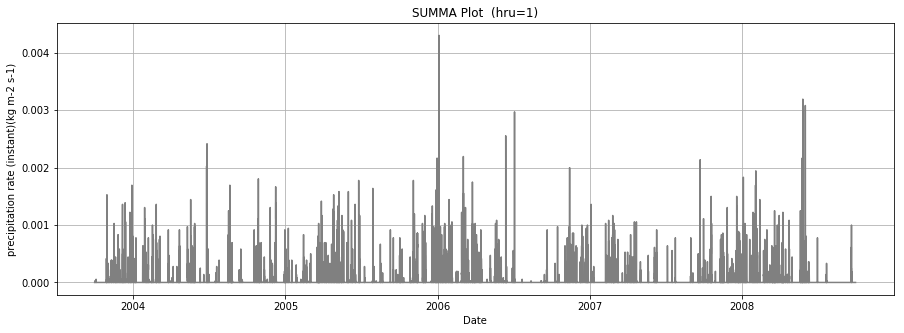

In [23]:
# timeseries plot with precipitaiton variable and hru 1
P.ts_plot('pptrate', hru_num = 0)

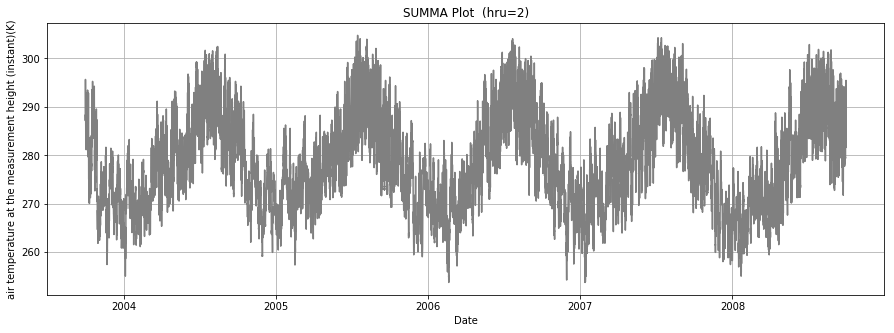

In [24]:
# timeseries plot with air temperature variable and hru 2
P.ts_plot('airtemp', hru_num = 1)

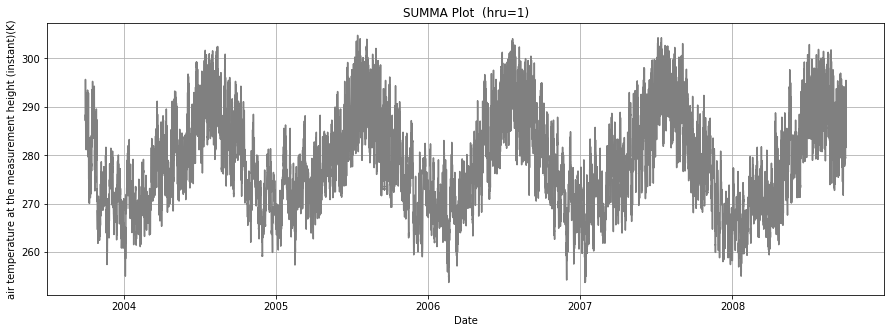

In [25]:
# timeseries plot with air temperature variable, if user doesn't set hru_num, default is hru 1.
P.ts_plot('airtemp')

#### 2) time series plot (variable, layer_num, hru_num) : [example] mLayerTemp, mLayerMatricHead, mLayerLiqFluxSoil...

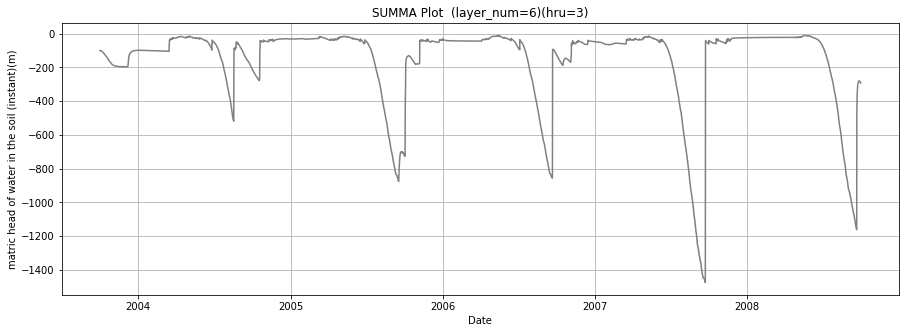

In [26]:
# timeseries plot with Matric head of water in the soil with soil layer and hru number
P.ts_plot_layer('mLayerMatricHead', layer_num = 5, hru_num = 2)

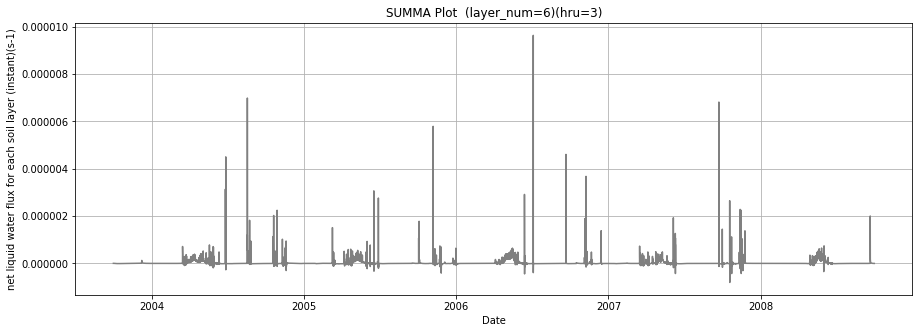

In [27]:
# timeseries plot with net liquid water flux for each soil layer with soil layer and hru number
P.ts_plot_layer('mLayerLiqFluxSoil', layer_num = 5, hru_num = 2)

#### 4.3) 2D Plotting

#### 1) heat map plot (plot for variable that include layer parameter : midToto, midSoil, ifcSoil, ifcToto)

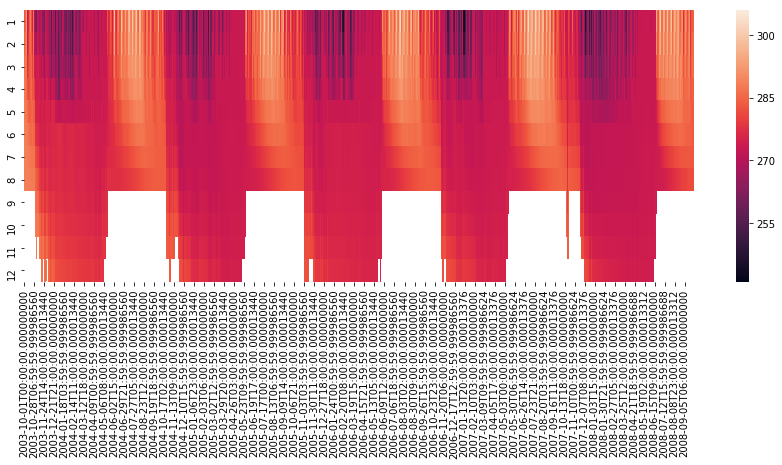

In [28]:
# heatmap plot using seaborn python library with temperature of each layer(unit:K), midToto layer, and hru 2
P.heatmap_plot('mLayerTemp', 'midToto', hru_num = 1)

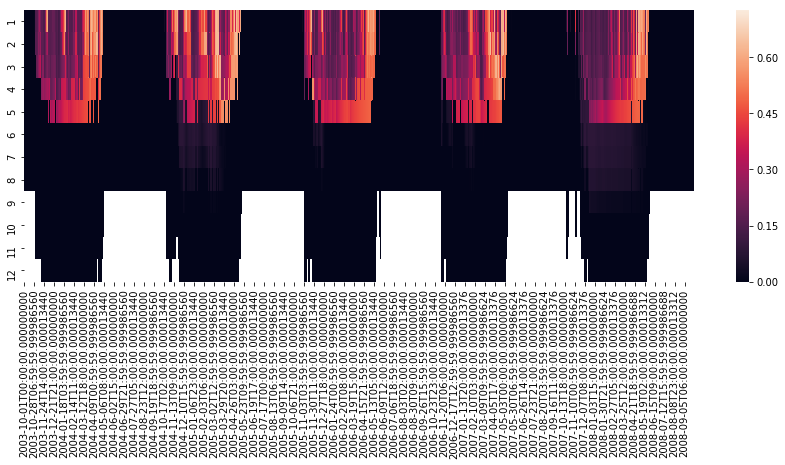

In [29]:
# heatmap plot using seaborn python library with volumetric fraction of ice in each layer, midToto layer, and hru 4
P.heatmap_plot('mLayerVolFracIce', 'midToto', hru_num = 3)

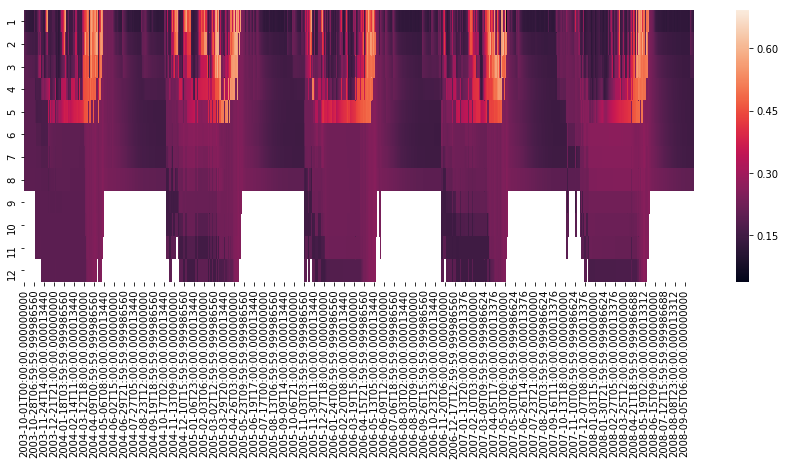

In [31]:
# heatmap plot using seaborn python library with volumetric fraction of total water in each layer, midToto layer, and hru 4
P.heatmap_plot('mLayerVolFracWat', 'midToto', hru_num = 3)

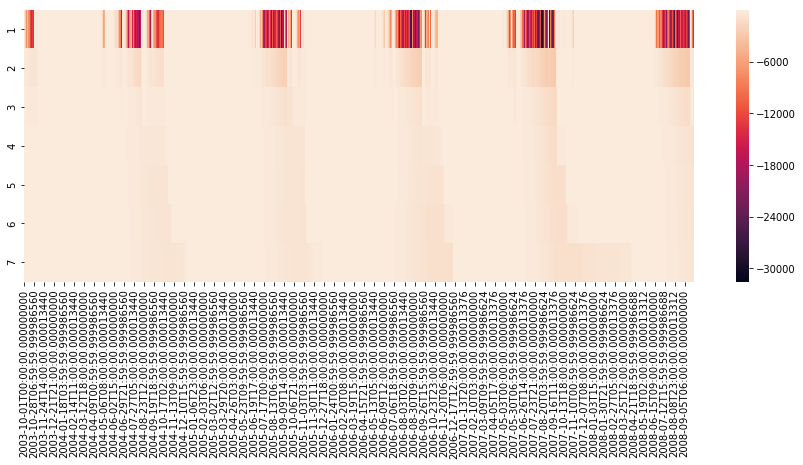

In [33]:
# heatmap plot using seaborn python library with matric head of water in the soil(unit:m), midToto layer, and hru 1
P.heatmap_plot('mLayerMatricHead', 'midSoil', hru_num = 0)

#### 2) hovmoller plot (plot for variable that include hru parameter : pptrate, airtemp, scalerSWE etc)

In [7]:
%pylab inline
from pysumma.plotting import hovmoller

Populating the interactive namespace from numpy and matplotlib


In [8]:
# create a Plot object using P object 
Plot = P.open_netcdf()

#### - description of time groups and aggretation method to set hovmoller plot
  * time groups = ['year', 'month', 'day', 'hour','minute', 'second', 'dayofyear','week', 'dayofweek', 'weekday', 'quarter']

  * aggregation method = ['mean', 'max', 'min, median', 'std']

True False False True


(<matplotlib.figure.Figure at 0x7f56b14b5a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f56b3657c18>)

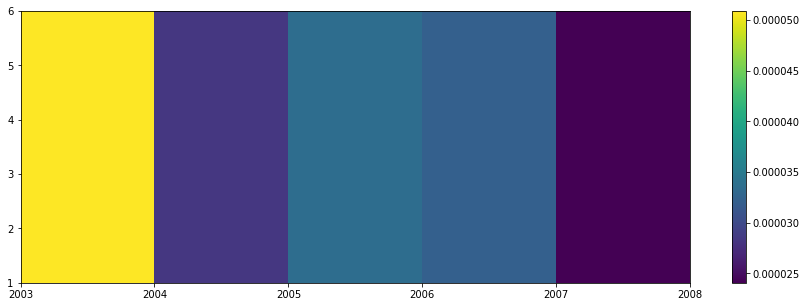

In [12]:
# hovmoller plot with yearly mean value of precipitation rate (unit : kg m-2 s-1)
hovmoller(Plot['pptrate'].isel(len(Plot.hru)), xdim='year', ydim='hru', how='mean')

True False False True


(<matplotlib.figure.Figure at 0x7f56b3605fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f56b15410b8>)

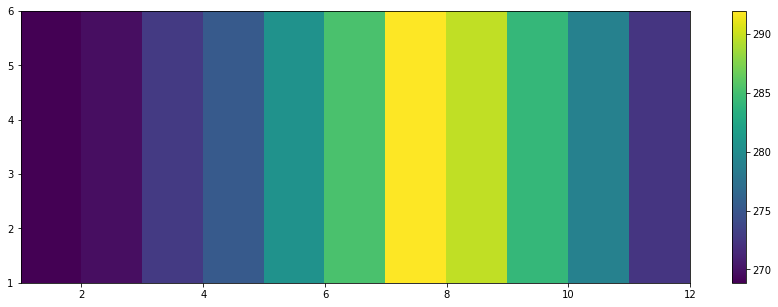

In [13]:
# hovmoller plot with monthly mean value of air temperature at the measurement height (unit : K)
hovmoller(Plot['airtemp'].isel(len(Plot.hru)), xdim='month', ydim='hru', how='mean')

True False False True


(<matplotlib.figure.Figure at 0x7f56b14210b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f56b12ecb38>)

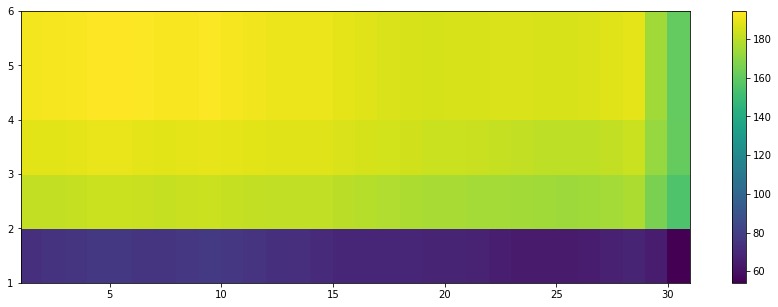

In [15]:
# hovmoller plot with daily mean value of snow water equivalent (unit : kg m-2) 
hovmoller(Plot['scalarSWE'].isel(len(Plot.hru)), xdim='day', ydim='hru', how='mean')

False True True False


(<matplotlib.figure.Figure at 0x7f56b11e5518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f56b1393080>)

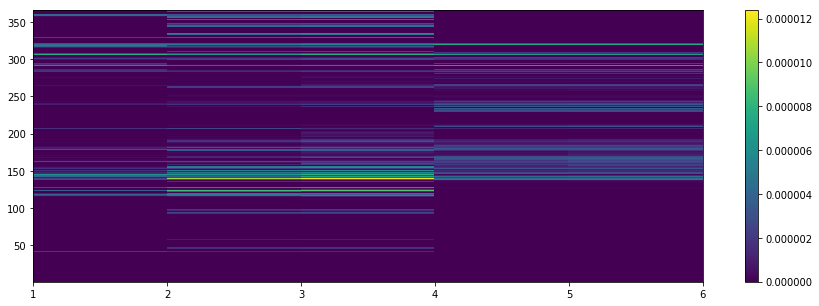

In [16]:
# hovmoller plot with day of year mean value of canopy evaporation/condensation (unit : kg m-2 s-1) 
hovmoller(Plot['scalarCanopyEvaporation'].isel(len(Plot.hru)), xdim='hru', ydim='dayofyear', how='max')

False True True False


(<matplotlib.figure.Figure at 0x7f56b10bda58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f56b10e09e8>)

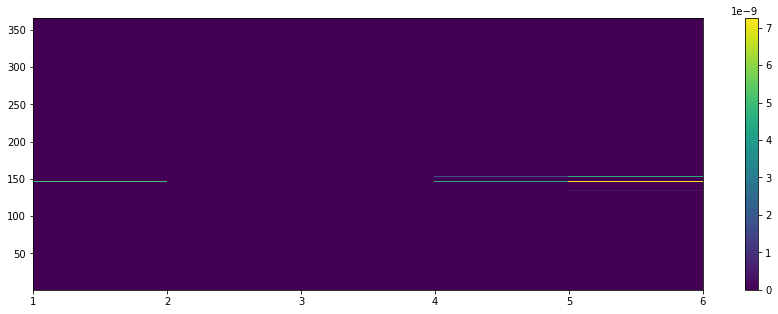

In [17]:
# hovmoller plot with day of year mean value of surface runoff (unit : m s-1) 
hovmoller(Plot['scalarSurfaceRunoff'].isel(len(Plot.hru)), xdim='hru', ydim='dayofyear', how='mean')

True False False True


(<matplotlib.figure.Figure at 0x7f56b14a48d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f56b1386b38>)

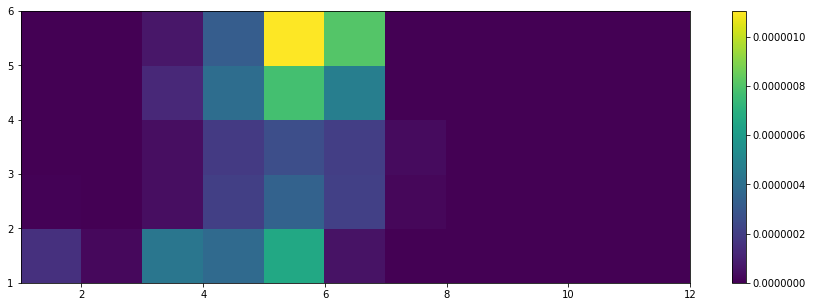

In [18]:
# hovmoller plot with monthly max value of total runoff (unit : m s-1) 
hovmoller(Plot['scalarTotalRunoff'].isel(len(Plot.hru)), xdim='month', ydim='hru', how='max')

#### 4.4) Plotting using water balance variables : Precipitation, Evapotranspiration, Snow water equivalent, Soil Moisture, Baseflow, and Runoff

In [25]:
import pysumma.plotting.waterbalance as wb

In [27]:
# create a water balance variable object using aggregate_wb_vars method
waterbalance_variable = wb.aggregate_wb_vars(Plot)

/home/hydro/miniconda3/lib/python3.6/_collections_abc.py:702: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  return len(self._mapping)
/home/hydro/miniconda3/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


In [28]:
# check water balance dataset 
waterbalance_variable

<xarray.Dataset>
Dimensions:        (hru: 6, time: 43825)
Coordinates:
  * time           (time) datetime64[ns] 2003-10-01 ...
  * hru            (hru) int32 1 2 3 4 5 6
Data variables:
    evaporation    (time, hru) float64 8.658 8.577 8.083 2.657 2.657 8.577 ...
    precipitation  (time, hru) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    runoff         (time, hru) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    swe            (time, hru) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    soil_moisture  (time, hru) float64 790.9 790.9 791.0 791.2 791.2 790.9 ...
    baseflow       (time, hru) float64 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 ...
Attributes:
    summaVersion:     v2.0.0
    buildTime:        Fri Sep 14 23:18:10 UTC 2018
    gitBranch:        sopron_2018-0-gdb0bd07
    gitHash:          db0bd07b19a6c0824a1a95e393719b8134c5ea8d
    soilStress:       NoahType
    stomResist:       BallBerry
    num_method:       itertive
    fDerivMeth:       analytic
    LAI_method: 

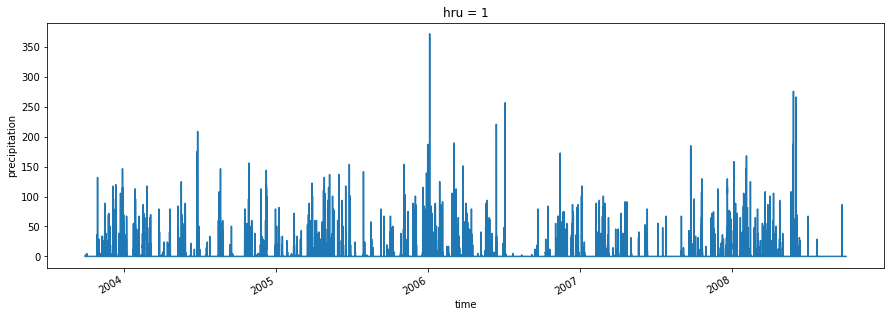

In [30]:
# Precipitation Plot in Hru 1 
waterbalance_variable["precipitation"][:,0].plot()

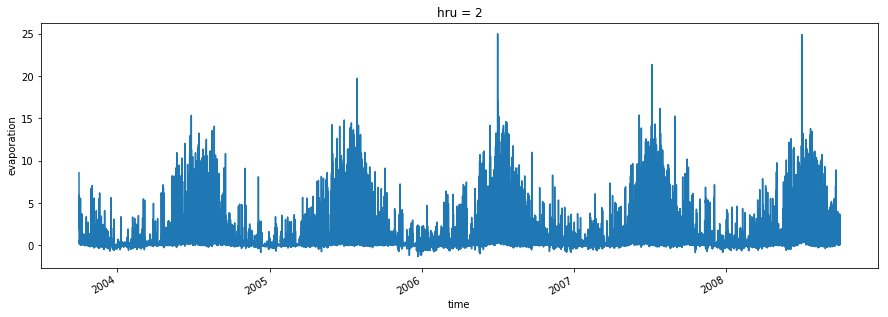

In [31]:
# Evapotranspiration Plot in Hru 2
waterbalance_variable["evaporation"][:,1].plot()

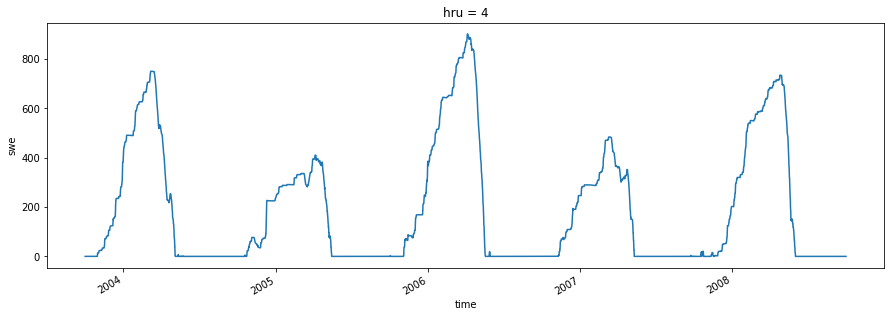

In [32]:
# Snow water equivalent Plot in Hru 4
waterbalance_variable["swe"][:,3].plot()

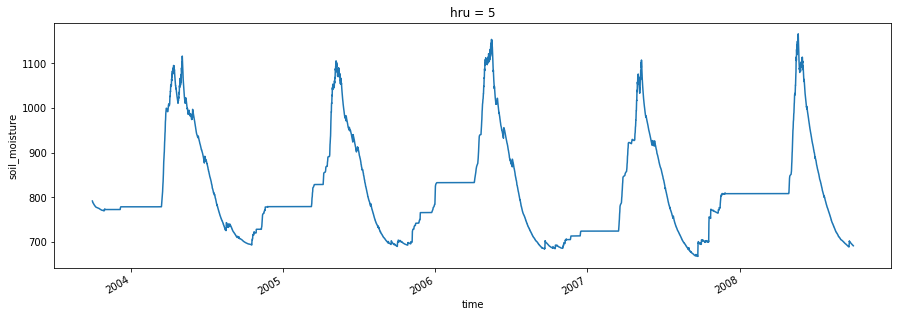

In [33]:
# Soil Moisture Plot in Hru 5
waterbalance_variable["soil_moisture"][:,4].plot()

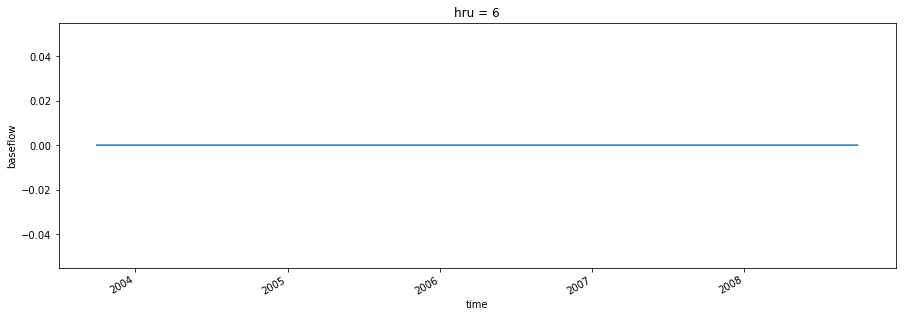

In [34]:
# Baseflow Plot in Hru 6
waterbalance_variable["baseflow"][:,5].plot()

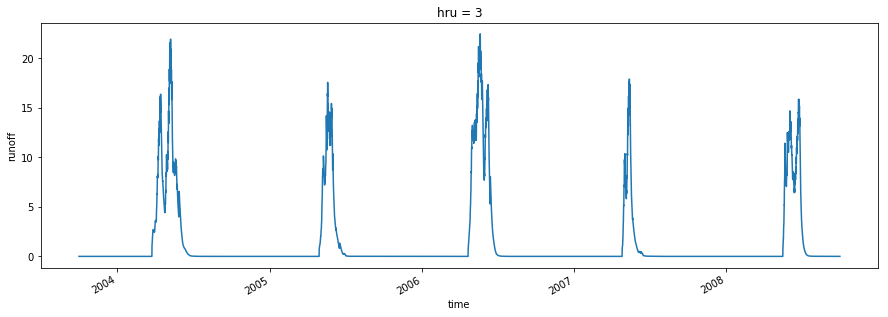

In [35]:
# Runoff Plot in Hru 3
waterbalance_variable["runoff"][:,2].plot()

In [37]:
# calculate Monthly mean of Evapotranspiration using calc_monthly_flux method (2006 year)
monthly_evapo_flux = wb.calc_monthly_flux(waterbalance_variable.evaporation, 2006)

/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


Text(0.5,1,'Monthly Evapotranspiration on Reynolds Mountain East catchment (2006year) ')

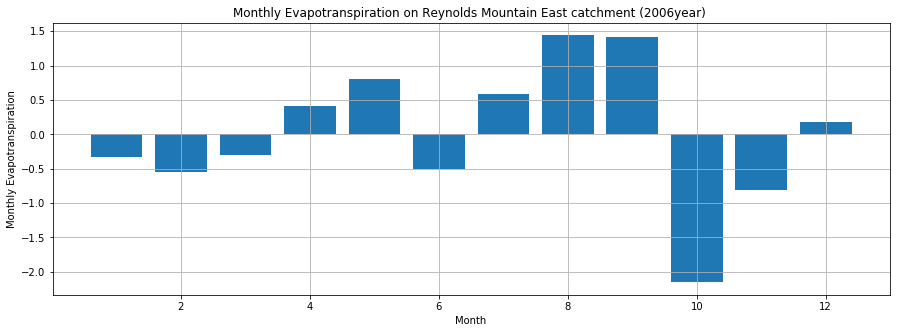

In [58]:
month = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.bar(month, monthly_evapo_flux)
ax = plt.gca()
ax.set_ylabel('Monthly Evapotranspiration')
ax.set_xlabel('Month')
ax.grid(True)
ax.set_title('Monthly Evapotranspiration on Reynolds Mountain East catchment (2006year) ')

In [40]:
# calculate Monthly sum of runoff using calc_monthly_flux method (2006 year)
monthly_runoff_sum = wb.calc_monthly_sum(waterbalance_variable.runoff, 2006)

/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


Text(0.5,1,'Monthly Runoff on Reynolds Mountain East catchment (2006year) ')

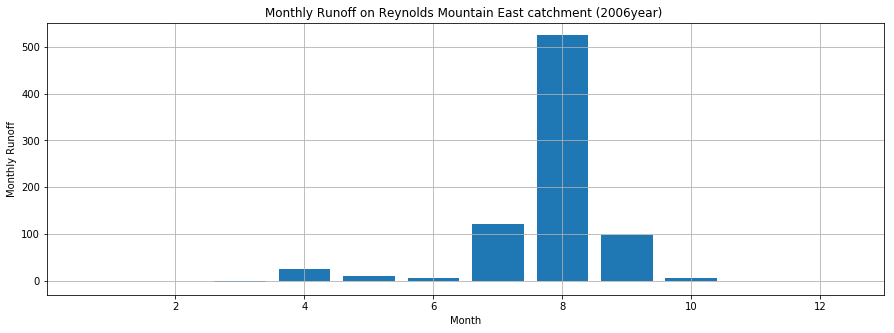

In [59]:
month = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.bar(month, monthly_runoff_sum)
ax = plt.gca()
ax.set_ylabel('Monthly Runoff')
ax.set_xlabel('Month')
ax.grid(True)
ax.set_title('Monthly Runoff on Reynolds Mountain East catchment (2006year) ')

In [60]:
# calculate seasonal mean of Evapotranspiration using calc_seasonal_flux method (2006 year)
seasonal_evapo_flux = wb.calc_seasonal_flux(waterbalance_variable.evaporation, 2006)

/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


Text(0.5,1,'Monthly Evapotranspiration on Reynolds Mountain East catchment (2006year) ')

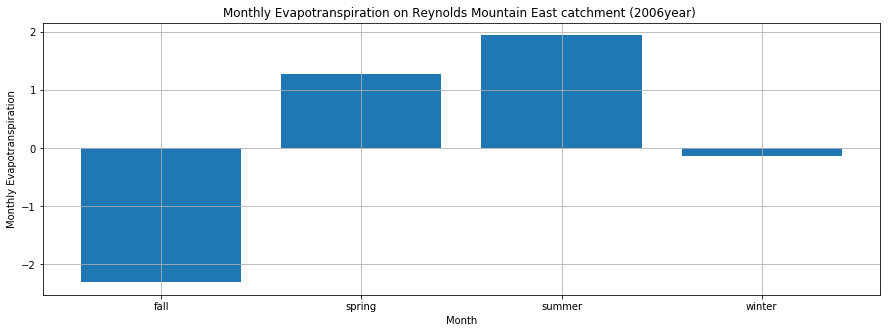

In [62]:
season = ['spring', 'summer', 'fall', 'winter']
plt.bar(season, seasonal_evapo_flux)
ax = plt.gca()
ax.set_ylabel('Seasonal Evapotranspiration')
ax.set_xlabel('Season')
ax.grid(True)
ax.set_title('Seasonal Evapotranspiration on Reynolds Mountain East catchment (2006year) ')

In [63]:
# calculate seasonal sum of runoff using calc_seasonal_sum method (2006 year)
seasonal_runoff_sum = wb.calc_seasonal_sum(waterbalance_variable.runoff, 2006)

/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


Text(0.5,1,'Seasonal Runoff on Reynolds Mountain East catchment (2006year) ')

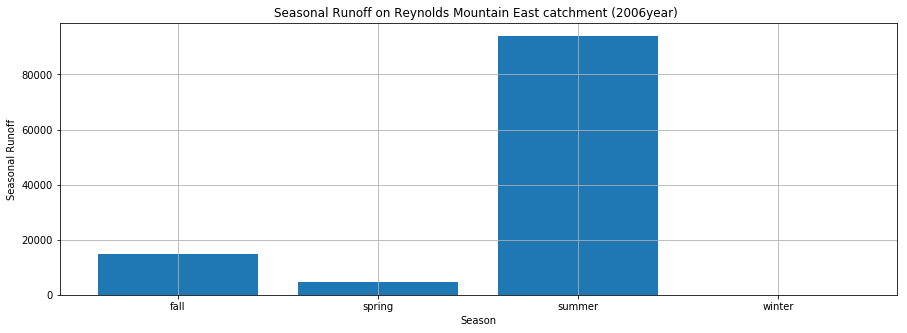

In [64]:
season = ['spring', 'summer', 'fall', 'winter']
plt.bar(season, seasonal_runoff_sum)
ax = plt.gca()
ax.set_ylabel('Seasonal Runoff')
ax.set_xlabel('Season')
ax.grid(True)
ax.set_title('Seasonal Runoff on Reynolds Mountain East catchment (2006year) ')

In [65]:
# calculate monthly water balance variables (2006 year)
monthly_balance = wb.monthly_water_balance(waterbalance_variable, 2006, agg_dims=['hru'])

/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=b

In [69]:
# Table of monthly water balance variables
monthly_balance

,evaporation,runoff,precipitation,soil_moisture,swe,baseflow
month,,,,,,
0,-20.314581,-0.005513,26.39736,-5.727353,-0.000166,0.0
1,-4.873938,-0.004788,170.79768,-82.192469,-82.634095,0.0
2,0.519873,3.524657,314.01324,-100.330358,-206.906170,0.0
3,-1.216464,-26.025885,232.40952,2.195926,-206.736175,0.0
4,-7.395930,-10.586842,73.99944,6.398025,-65.351358,0.0
5,-7.935834,-6.880060,166.31640,-1.383536,-151.569699,0.0
6,-13.378620,-121.543797,95.02596,-190.508721,219.862007,0.0
7,-50.321008,-524.244159,68.27688,66.794468,443.255679,0.0
8,-101.718192,-98.631124,34.30044,118.768747,50.079978,0.0


Text(0.5,1,'Runoff(2006)')

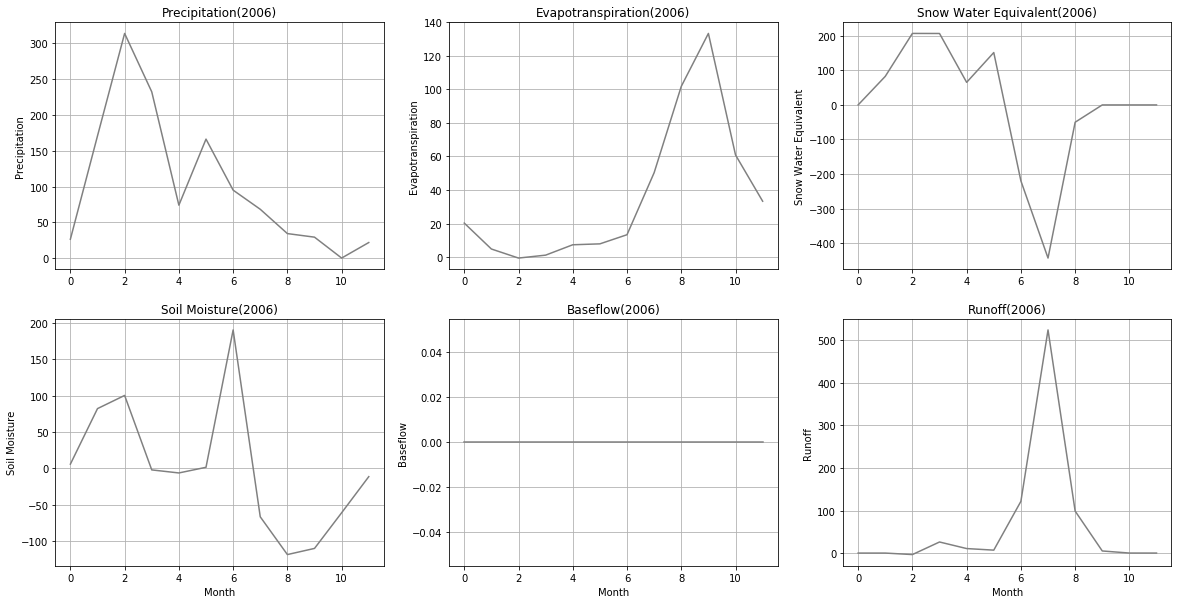

In [83]:
fig = plt.figure(figsize=(20, 10))  # figsize=(width, height)

# Add the first subplot to the figure
ax = fig.add_subplot(2, 3, 1)  # (rows, columns, specific subplot assigned to ax)
ax.plot(monthly_balance.index, monthly_balance['precipitation'], color='grey', linestyle='solid', markersize=0)
# Set properties of the first subplot
ax.set_ylabel("Precipitation")
ax.grid(True)
ax.set_title("Precipitation(2006)")

# Add the first subplot to the figure
ax1 = fig.add_subplot(2, 3, 2)  # (rows, columns, specific subplot assigned to ax)
ax1.plot(monthly_balance.index, monthly_balance['evaporation'], color='grey', linestyle='solid', markersize=0)
# Set properties of the first subplot
ax1.set_ylabel("Evapotranspiration")
ax1.grid(True)
ax1.set_title("Evapotranspiration(2006)")

# Add the first subplot to the figure
ax2 = fig.add_subplot(2, 3, 3)  # (rows, columns, specific subplot assigned to ax)
ax2.plot(monthly_balance.index, monthly_balance['swe'], color='grey', linestyle='solid', markersize=0)
# Set properties of the first subplot
ax2.set_ylabel("Snow Water Equivalent")
ax2.grid(True)
ax2.set_title("Snow Water Equivalent(2006)")

# Add the first subplot to the figure
ax3 = fig.add_subplot(2, 3, 4)  # (rows, columns, specific subplot assigned to ax)
ax3.plot(monthly_balance.index, monthly_balance['soil_moisture'], color='grey', linestyle='solid', markersize=0)
# Set properties of the first subplot
ax3.set_ylabel("Soil Moisture")
ax3.set_xlabel("Month")
ax3.grid(True)
ax3.set_title("Soil Moisture(2006)")

# Add the first subplot to the figure
ax4 = fig.add_subplot(2, 3, 5)  # (rows, columns, specific subplot assigned to ax)
ax4.plot(monthly_balance.index, monthly_balance['baseflow'], color='grey', linestyle='solid', markersize=0)
# Set properties of the first subplot
ax4.set_ylabel("Baseflow")
ax4.set_xlabel("Month")
ax4.grid(True)
ax4.set_title("Baseflow(2006)")

# Add the first subplot to the figure
ax5 = fig.add_subplot(2, 3, 6)  # (rows, columns, specific subplot assigned to ax)
ax5.plot(monthly_balance.index, monthly_balance['runoff'], color='grey', linestyle='solid', markersize=0)
# Set properties of the first subplot
ax5.set_ylabel("Runoff")
ax5.set_xlabel("Month")
ax5.grid(True)
ax5.set_title("Runoff(2006)")

/home/hydro/miniconda3/lib/python3.6/_collections_abc.py:702: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  return len(self._mapping)
/home/hydro/miniconda3/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping
/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/home/hydro/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper 

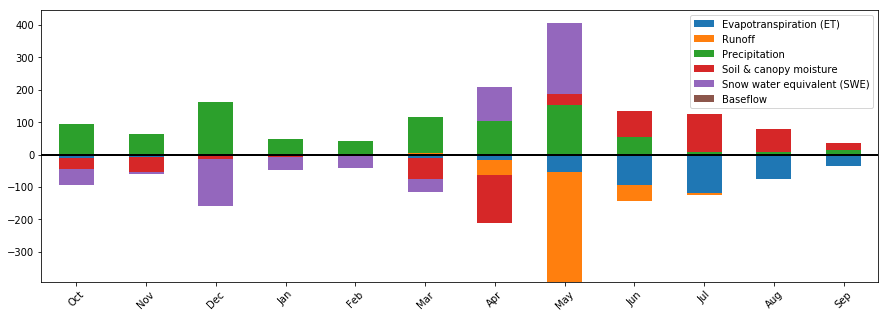

In [76]:
# monthly Plot of water balance variables from 2005 to 2006 year 
water_balance = wb.water_balance(Plot, 2005, 2006, how='monthly')

#### 4.5) Spatial Plotting

In [84]:
from pysumma.plotting import spatial
import geopandas as gp

In [85]:
# set shapefile using geopandas
gdf = gp.GeoDataFrame.from_file(os.getcwd() + '/data/map/ReynoldsMountainEast_subwatershed.shp')

In [90]:
# check data of evapotranspiration
waterbalance_variable['evaporation']

<xarray.DataArray 'evaporation' (time: 43825, hru: 6)>
array([[ 8.65848 ,  8.577229,  8.083151,  2.657387,  2.657387,  8.577229],
       [ 7.60482 ,  7.505755,  7.161307,  1.668623,  1.668623,  7.505755],
       [ 7.161738,  7.298871,  7.046966,  1.503994,  1.503994,  7.298871],
       ..., 
       [ 0.150749,  0.216625,  0.150003,  0.167764,  0.182785,  0.234442],
       [ 0.15743 ,  0.186467,  0.136764,  0.084864,  0.092375,  0.203552],
       [ 0.145104,  0.196415,  0.147026,  0.098148,  0.108478,  0.214222]])
Coordinates:
  * time     (time) datetime64[ns] 2003-10-01 2003-10-01T00:59:59.999986560 ...
  * hru      (hru) int32 1 2 3 4 5 6

(<matplotlib.figure.Figure at 0x7f56adf8ea58>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f56ae018d68>)

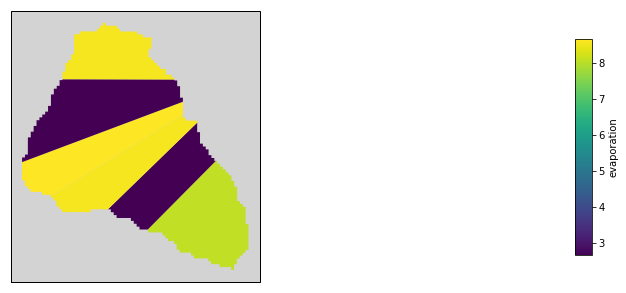

In [94]:
# spatial plot with variables of evapotranspiration at specific time = 0 [time range : 0 ~ 43824] 
spatial(waterbalance_variable['evaporation'].isel(time=0), gdf)

(<matplotlib.figure.Figure at 0x7f56ade82ef0>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f56adebe7b8>)

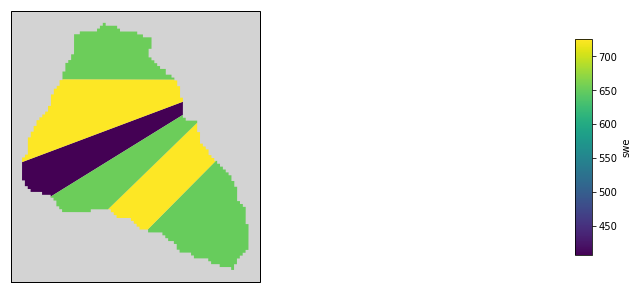

In [96]:
# spatial plot with variables of Snow water equivalent at specific time = 40000 [time range : 0 ~ 43824] 
spatial(waterbalance_variable['swe'].isel(time=40000), gdf)

(<matplotlib.figure.Figure at 0x7f56ae299240>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f56ade5b208>)

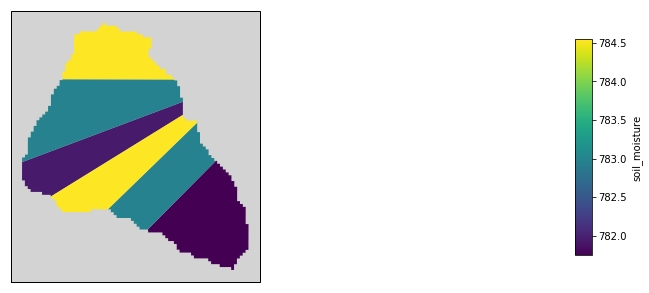

In [97]:
# spatial plot with variables of Snow water equivalent at specific time = 100 [time range : 0 ~ 43824] 
spatial(waterbalance_variable['soil_moisture'].isel(time=100), gdf)

(<matplotlib.figure.Figure at 0x7f56ad8ad438>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f56ad8dfba8>)

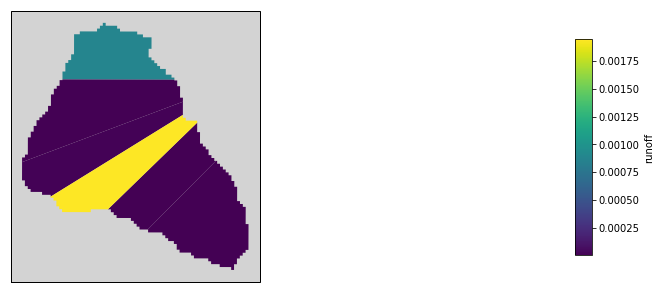

In [107]:
# spatial plot with variables of runoff at specific time = 100 [time range : 0 ~ 43824] 
spatial(waterbalance_variable['runoff'].isel(time=43480), gdf)